# Neural Network Final Model - Jungfraujoch, Switzerland

In [1]:
import pandas as pd
from joblib import dump
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance

import sys
sys.path.append('../../')
import config

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [2]:
site = config.site
site_name = config.site_dict[site]
assert site == 'JFJ', 'This script is only for Jungfraujoch, Switzerland. The site can be changed in the config file.'

compound = config.compound

print(f"Creating a neural network model for \033[1m{site_name}\033[0;0m.")

Creating a neural network model for Jungfraujoch, Switzerland.


### Loading & Initialising Data

In [4]:
data = pd.read_csv(data_path/f'for_model_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,flag,u10_0,u10_1,u10_2,u10_3,u10_4,u10_5,u10_6,u10_7,...,v500_7_past,v500_8_past,v500_9_past,v500_10_past,v500_11_past,v500_12_past,v500_13_past,v500_14_past,v500_15_past,v500_16_past
4146,2007-03-28 23:00:00,0.0,-0.720127,-1.060147,-3.769863,0.113933,-0.737748,-9.218665,-7.091746,0.669974,...,10.641770,7.068478,6.922430,4.303313,0.020880,-2.977960,3.097611,1.598191,3.245281,12.003257
16903,2019-04-25 11:00:00,1.0,-1.800736,-0.219228,-1.048489,0.358922,0.530306,-4.825450,3.790403,2.925889,...,24.379295,25.548227,15.006354,5.883324,2.552544,5.085226,4.640495,4.944149,16.683167,17.146708
971,2004-01-25 23:00:00,1.0,-1.136524,0.743922,-0.502106,0.679100,-0.793806,0.800942,1.118451,-3.239647,...,-15.976497,-11.753719,3.953345,10.398124,-6.024098,-6.839435,-16.347990,-5.087713,-0.337610,-0.963722
21205,2022-07-07 15:00:00,1.0,1.688005,4.211962,4.098699,-0.270567,2.057160,8.629703,2.740935,0.668168,...,-11.263090,-24.078240,-17.107368,0.061173,-4.105533,-7.699220,0.398243,0.066359,-11.194378,-16.368406
10293,2013-10-17 05:00:00,1.0,0.956051,4.966564,2.366607,0.450116,-1.251883,7.503506,-2.553376,2.579887,...,-17.215614,-10.755186,-8.130733,-3.692050,6.682170,1.361548,-13.979297,-3.402139,-7.524972,0.186648


In [5]:
train_data = data[(data['time'].dt.year >= 2018) & (data['time'].dt.year <= 2018)]
val_data = data[(data['time'].dt.year >= 2019) & (data['time'].dt.year <= 2019)]
test_data = data[(data['time'].dt.year >= 2020) & (data['time'].dt.year <= 2023)]


print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2018-01-01 07:00:00 -> 2018-12-31 21:00:00. Length: 1082
Val range: 2019-01-01 03:00:00 -> 2019-12-31 23:00:00. Length: 1380
Test range: 2020-01-01 01:00:00 -> 2022-12-31 23:00:00. Length: 4206


### Model

In [119]:
nn_model = MLPClassifier(random_state=42,
                         max_iter=200, 
                         hidden_layer_sizes=(100,), 
                         shuffle=False,
                         activation='relu', 
                         solver='adam', 
                         alpha=0.001, 
                         learning_rate='invscaling', 
                         batch_size=100, 
                         early_stopping=True,
                         validation_fraction=0.1,
                         learning_rate_init=0.01,
                         epsilon=2e-10,
                         beta_2=0.8,
                         tol=1e-3,)

nn_model.fit(X_train, y_train)

y_pred_val = nn_model.predict(X_val)
y_pred_train = nn_model.predict(X_train)


precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")

Precision on Training Set = 0.904
Precision on Validation Set = 0.908
Recall on Training Set = 0.948
Recall on Validation Set = 0.914
F1 Score on Training Set = 0.926
F1 Score on Validation Set = 0.911


In [121]:
# evaluating model on test set

y_pred_test = nn_model.predict(X_test)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Precision on Testing Set = {precision_test:.3f}")
print(f"Recall on Testing Set = {recall_test:.3f}")
print(f"F1 Score on Testing Set = {f1_test:.3f}")

Precision on Testing Set = 0.903
Recall on Testing Set = 0.938
F1 Score on Testing Set = 0.920


In [122]:
# saving the model
dump(nn_model, data_path/f'nn_model_{site}.joblib')

['C:\\Users\\kirst\\OneDrive\\Kirstin\\Uni\\Year4\\MSciProject\\data_files\\saved_files\\nn_model_JFJ.joblib']

### Assessing Feature Importance

In [123]:
# finding most important features in the model using permutation importance
# using the testing set
perm_importance = permutation_importance(nn_model, X_train, y_train, n_repeats=30, random_state=42)
sorted_importances = perm_importance.importances_mean.argsort()

Text(0.5, 0, 'Permutation Importance')

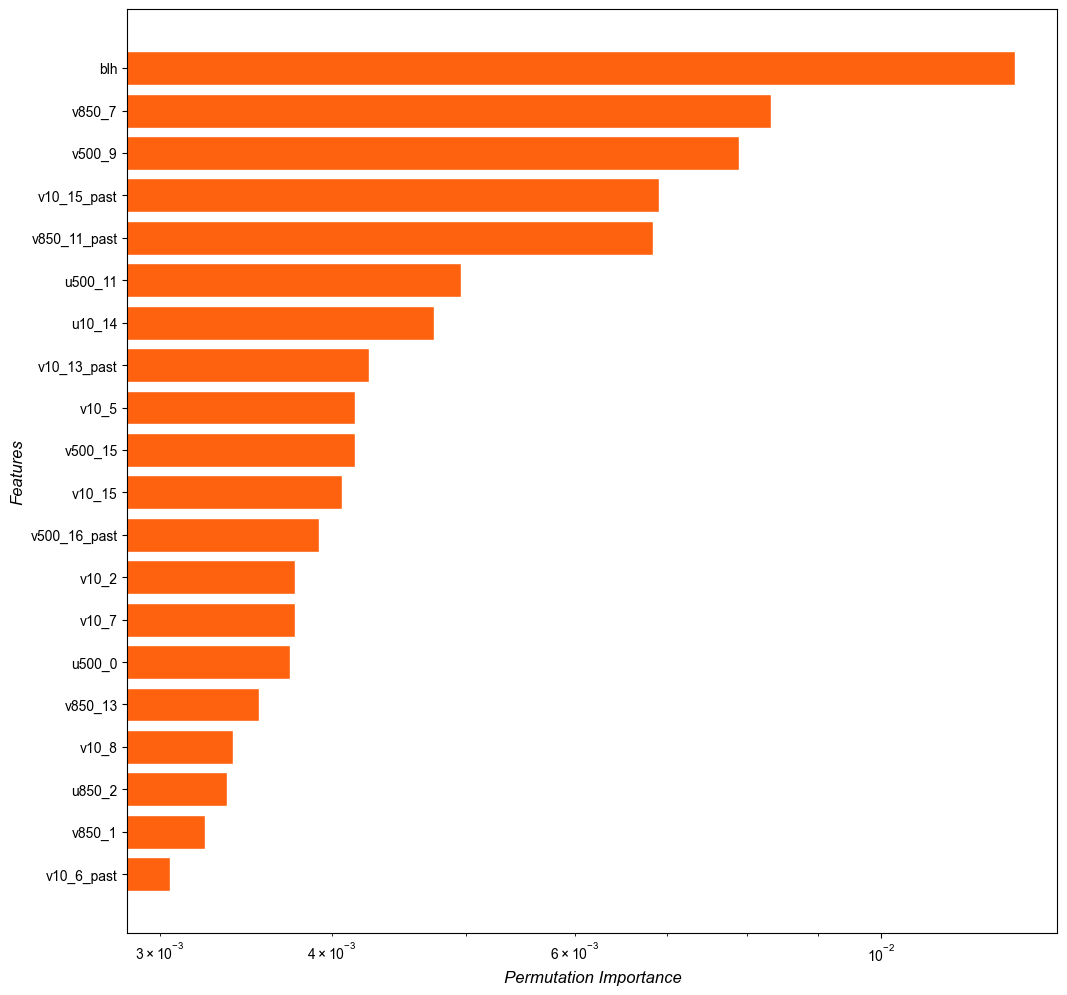

In [124]:
# plotting first 20 most important features in a histogram

fig, ax = plt.subplots(figsize=(12, 12))
sns.set_theme(style='ticks', font='Arial')

ax.barh(X_val.columns[sorted_importances][-20:], perm_importance.importances_mean[sorted_importances][-20:], color='#FF620E')

ax.set_xscale('log')

ax.set_ylabel('Features', fontsize=12, fontstyle='italic')
ax.set_xlabel('Permutation Importance', fontsize=12, fontstyle='italic')
# ax.set_title('Permutation Importance (Testing Set)', fontsize=14)